In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools

In [4]:
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    plot_relative_results,
    print_example,
    bottom_quartile_outcome,
)

In [5]:
results = {
    "llama3-8B": current_transducer_experiments(),
    "gpt-3.5": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-3.5-turbo-0125"
    ),
    "gpt-4o": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18"
    ),
}

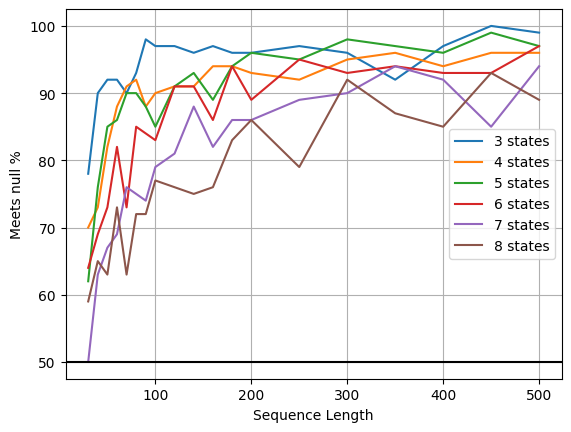

In [6]:
plot_relative_results(compute_relative_to_null(results["llama3-8B"]), "null")

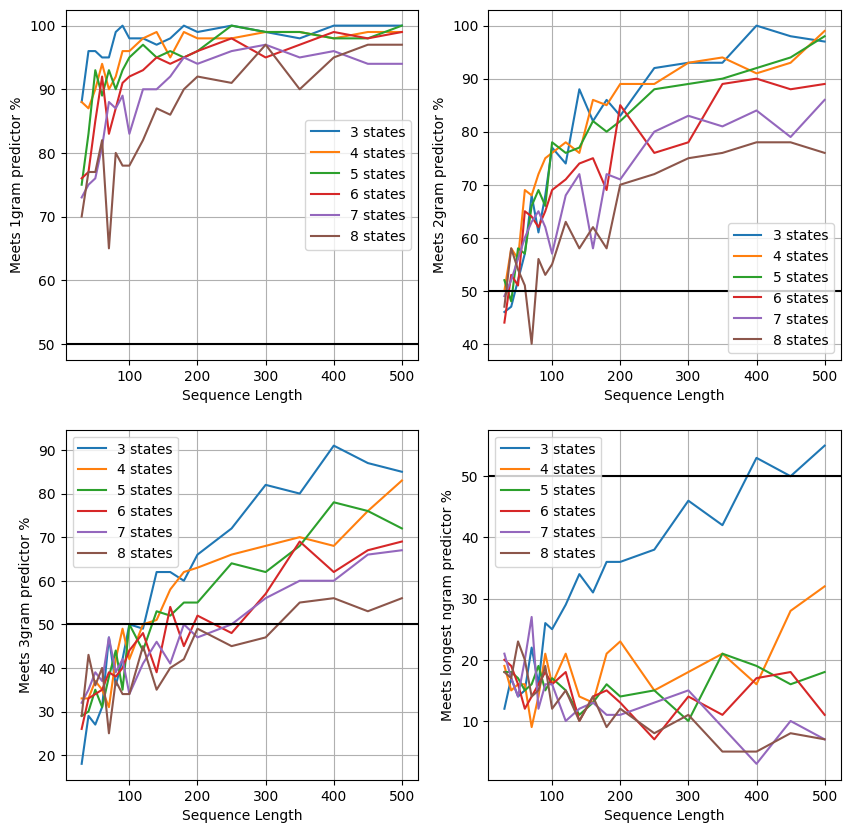

In [7]:
_, axs = plt.subplots(2, 2, figsize=(10, 10))
gram_1, gram_2, gram_3, gram_inf = axs.flatten()
plot_relative_results(
    compute_relative_to_ngram(1, results["llama3-8B"]), "1gram predictor", ax=gram_1
)
plot_relative_results(
    compute_relative_to_ngram(2, results["llama3-8B"]), "2gram predictor", ax=gram_2
)
plot_relative_results(
    compute_relative_to_ngram(3, results["llama3-8B"]), "3gram predictor", ax=gram_3
)
plot_relative_results(
    compute_relative_to_ngram(10**9, results["llama3-8B"]),
    "longest ngram predictor",
    ax=gram_inf,
)

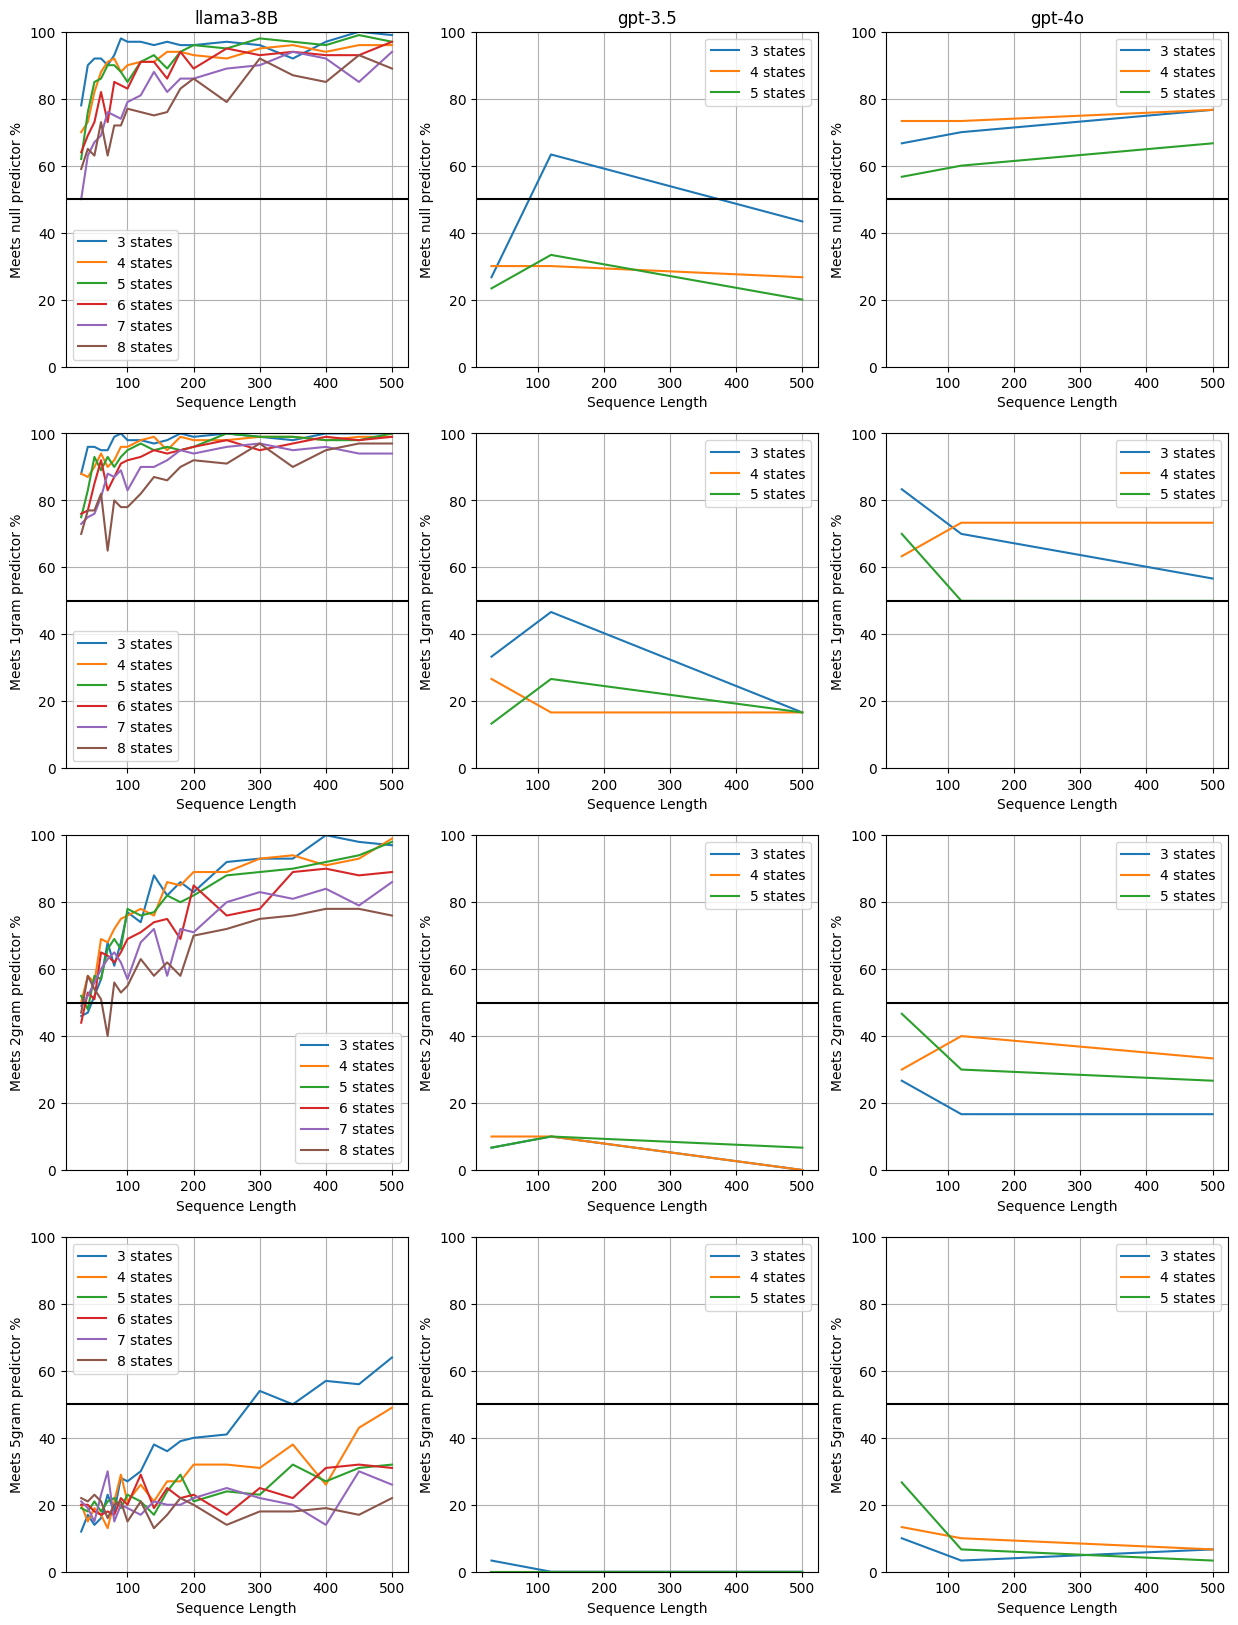

In [8]:
_, axs = plt.subplots(4, 3, figsize=(15, 20))

for (ax_null, ax_1gram, ax_2gram, ax_5gram), name in zip(axs.T, results):
    ax_null.set_title(name)
    plot_relative_results(
        compute_relative_to_null(results[name]), "null predictor", ax=ax_null
    )
    plot_relative_results(
        compute_relative_to_ngram(1, results[name]), "1gram predictor", ax=ax_1gram
    )
    plot_relative_results(
        compute_relative_to_ngram(2, results[name]), "2gram predictor", ax=ax_2gram
    )
    plot_relative_results(
        compute_relative_to_ngram(5, results[name]), "5gram predictor", ax=ax_5gram
    )
for ax in axs.flatten():
    ax.set_ylim(0, 100)

In [9]:
prompter = evallm.prompting.transducer_prompt.ChainOfThoughtPrompt(30)

In [10]:
print_example(
    "gpt-3.5-turbo-0125", prompter, bottom_quartile_outcome(results["gpt-3.5"][3][30])
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############
You are a question answering system. For each question, think step by step and place your answer between tags like <answer>0</answer> or <answer>1</answer>. MAKE SURE TO PUT YOUR ANSWER IN ANSWER TAGS or you will get NO CREDIT.
QUESTION:
What is 20*2?
ANSWER:
To solve this problem, we need to multiply 20 by 0. We can accomplish this via noticing that anything multiplied by 0 is 0. <answer>0</answer>

######### USER ############
QUESTION:
A DFA was used to create these outputs given a random sequence of inputs. Your job is to fill in the last output:
in: a, out: 0
in: c, out: 1
in: b, out: 0
in: a, out: 1
in: b, out: 0
in: a, out: 1
in: c, out: 1
in: a, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 1
in: b, out: 0
in: c, out: 1
in: b, out: 0
in: a, out: 1
in: a, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 1
in: b, out: 0
in: c, out: 1
in: b, out: 0
in: b, out: 1
in: c, out: 1
in: c, out: 1
in: b, out: 0
in: c, out:

In [11]:
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter,
    bottom_quartile_outcome(results["gpt-4o"][3][30]),
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############
You are a question answering system. For each question, think step by step and place your answer between tags like <answer>0</answer> or <answer>1</answer>. MAKE SURE TO PUT YOUR ANSWER IN ANSWER TAGS or you will get NO CREDIT.
QUESTION:
What is 20*2?
ANSWER:
To solve this problem, we need to multiply 20 by 0. We can accomplish this via noticing that anything multiplied by 0 is 0. <answer>0</answer>

######### USER ############
QUESTION:
A DFA was used to create these outputs given a random sequence of inputs. Your job is to fill in the last output:
in: b, out: 1
in: c, out: 0
in: b, out: 0
in: b, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 0
in: a, out: 1
in: b, out: 1
in: c, out: 0
in: c, out: 0
in: b, out: 0
in: b, out: 0
in: a, out: 1
in: b, out: 1
in: b, out: 1
in: a, out: 0
in: c, out: 0
in: a, out: 1
in: c, out: 0
in: c, out: 0
in: b, out: 0
in: c, out: 0
in: c, out: 0
in: a, out: 1
in: b, out: 1
in: a, out: